In [74]:
!pip install tensorflow-gpu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [110]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
import os
import random


In [111]:
p="./dataset/train"
files = os.listdir(p)
categories = []
for filename in files:
    s = filename.split(".")[0]
    if (s=="dog"):
        categories.append(1)
    else: 
        categories.append(0)

In [112]:
categories = np.array(categories)
(unique, counts) = np.unique(categories, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[    0 12500]
 [    1 12500]]


In [113]:
df=pd.DataFrame({
    'filename':files,
    'category':categories
})
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


In [114]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15
train_df.shape,validate_df.shape

((20000, 2), (5000, 2))

In [115]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3
batch_size=15
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./dataset/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [12]:
# model building
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization
model = keras.Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(), 
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(2, activation='softmax')
])

In [13]:
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [17]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\NEERAJ\AppData\Local\Temp\ipykernel_17344\2528005629.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
1333/1333 [==============================] - 72s 54ms/step - loss: 0.4933 - accuracy: 0.7617 - val_loss: 0.8412 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 69s 52ms/step - loss: 0.4605 - accuracy: 0.7868 - val_loss: 0.5634 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 68s 51ms/step - loss: 0.4319 - accuracy: 0.8055 - val_loss: 0.9141 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 68s 51ms/step - loss: 0.4180 - accuracy: 0.8114 - val_loss: 0.3855 - val_accuracy: 0.8398 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 69s 52ms/step - loss: 0.3948 - accuracy: 0.8240 - val_loss: 0.4204 - val_accuracy: 0.8070 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - 69s 52ms/step - loss: 0.3851 - accuracy: 0.8307 - val_loss: 0.3332 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 7/10
1333/1333 [========================

In [18]:
model.save("model1_catsVSdogs_10epoch.h5")

In [116]:
test_file_name = os.listdir("./dataset/test1")

test_df = pd.DataFrame({
    'filename': test_file_name
})
nb_samples = test_df.shape[0]

In [117]:
nb_samples

12500

In [118]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dataset/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=Image_Size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [119]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\NEERAJ\AppData\Local\Temp\ipykernel_17344\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [120]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [121]:
validate_df


,filename,category
0,cat.493.jpg,cat
1,dog.9112.jpg,dog
2,cat.745.jpg,cat
3,dog.11022.jpg,dog
4,dog.11363.jpg,dog
...,...,...
4995,cat.6551.jpg,cat
4996,cat.9403.jpg,cat
4997,cat.236.jpg,cat
4998,dog.6530.jpg,dog


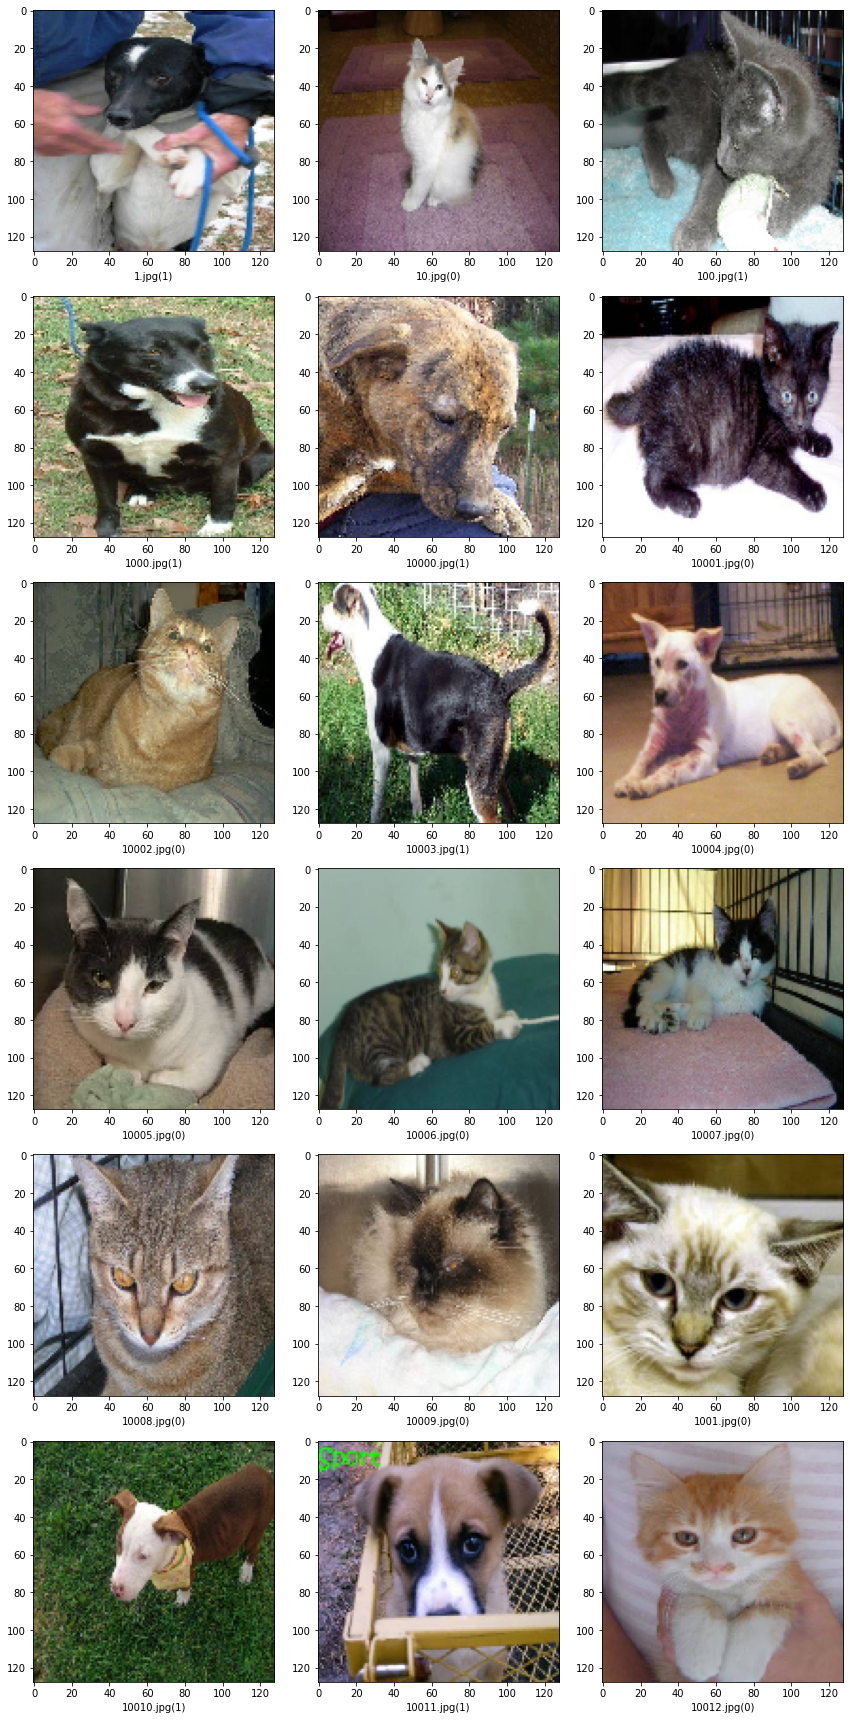

In [122]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dataset/test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [123]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [124]:
predicted_val = model.predict_generator(validation_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\NEERAJ\AppData\Local\Temp\ipykernel_17344\2925549271.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_val = model.predict_generator(validation_generator, steps=np.ceil(nb_samples/batch_size))


In [128]:
predicted_val = np.argmax(predicted_val,axis=1)
predicted_val

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [129]:
truth = np.array(validate_df['category'].replace({ 'dog': 1, 'cat': 0 }))
truth

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [130]:
from sklearn.metrics import confusion_matrix
confusion_matrix(truth, predicted_val)

array([[2335,  180],
       [ 363, 2122]], dtype=int64)